## Task A: optimize a region

In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import pypsa 
import warnings
warnings.filterwarnings("ignore")

# Import datasets
country = "FIN"
year = 2015

demand = pd.read_csv("electricity_demand.csv", sep=";", index_col=0, parse_dates=True)
demand = demand[country].loc[demand.index.year == year]

onshore = pd.read_csv("onshore_wind_1979-2017.csv", sep=";", index_col=0, parse_dates=True)
onshore = onshore[country].loc[onshore.index.year == year]

solar = pd.read_csv("pv_optimal.csv", sep=";", index_col=0, parse_dates=True)
solar = solar[country].loc[solar.index.year == year]

heat = pd.read_csv("heat_demand.csv", sep=";", index_col=0, parse_dates=True)
heat = heat[country].loc[solar.index.year == year]

snapshots = demand.index


In [35]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_2030.csv"
costs = pd.read_csv(url, index_col=[0, 1])

# Convert costs to MW
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

# Define default values for missing parameters 
defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}

costs = costs.value.unstack().fillna(defaults)

# Set OCGT cost and emissions to gas values
costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

# Set OCGT cost and emissions to gas values
costs.at["biomass CHP", "CO2 intensity"] = costs.at["solid biomass", "CO2 intensity"]
costs.at["biomass CHP", "fuel"] = costs.at["solid biomass", "fuel"]

# Compute marginal costs
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

# Compute capital costs
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

# Extract relevant costs with nicer names
wind_capital = costs.at["onwind", "capital_cost"] #EUR/MW/a
wind_marginal = costs.at["onwind", "marginal_cost"] #EUR/MWh
solar_capital = costs.at["solar", "capital_cost"] #EUR/MW/a
solar_marginal = costs.at["solar", "marginal_cost"] #EUR/MWh
gas_capital = costs.at["OCGT", "capital_cost"] #EUR/MW/a
gas_marginal = costs.at["OCGT", "marginal_cost"] #EUR/MWh
nuclear_capital = costs.at["nuclear", "capital_cost"] #EUR/MW/a
nuclear_marginal = costs.at["nuclear", "marginal_cost"] #EUR/MWh
pumped_hydro_capital = costs.at["Pumped-Storage-Hydro-store", "capital_cost"] 
pumped_hydro_marginal = costs.at["Pumped-Storage-Hydro-store", "marginal_cost"] #EUR/MWh
biomass_capital = costs.at["biomass CHP", "capital_cost"] #EUR/MW/a
biomass_marginal = costs.at["biomass CHP", "marginal_cost"] #EUR/MWh
coal_capital = costs.at["coal", "capital_cost"] #EUR/MW/a
coal_marginal = costs.at["coal", "marginal_cost"] #EUR/MWh

In [37]:
# Create a PyPSA network
network = pypsa.Network()
network.set_snapshots(snapshots)


# Add buses
network.add("Bus", "FIN_el")
network.add("Bus", "FIN_hydro")

# Add carriers
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "nuclear",
    "Pumped-Storage-Hydro-store",
    "biomass CHP",
    "coal"
]

colors = ["dodgerblue", "gold", "brown", "blue", "green", "orange", "red"]

for i in range(len(carriers)):
    network.add("Carrier", carriers[i], co2_emissions=costs.at[carriers[i], "CO2 intensity"], color=colors[i])


# Add loads
network.add("Load", "FIN_el_load", bus="FIN_el", p_set=demand.values)


# Add generators
network.add("Generator", "FIN_onshore_wind", bus="FIN_el", p_nom_extendable=True, p_max_pu=onshore.values, marginal_cost=wind_marginal, capital_cost=wind_capital, carrier="onwind")
network.add("Generator", "FIN_solar", bus="FIN_el", p_nom_extendable=True, p_max_pu=solar.values, marginal_cost=solar_marginal, capital_cost=solar_capital, carrier="solar")
network.add("Generator", "FIN_OCGT", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=gas_marginal, efficiency = costs.at["OCGT","efficiency"], capital_cost=gas_capital, carrier="OCGT")
network.add("Generator", "FIN_nuclear", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=nuclear_marginal, efficiency = costs.at["nuclear","efficiency"], capital_cost=nuclear_capital, carrier="nuclear")
network.add("Generator", "FIN_biomass", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=biomass_marginal, efficiency = costs.at["biomass CHP","efficiency"], capital_cost=biomass_capital, carrier="biomass CHP")
network.add("Generator", "FIN_coal", bus="FIN_el", p_nom_extendable=True, p_max_pu=1, marginal_cost=coal_marginal, efficiency = costs.at["coal","efficiency"], capital_cost=coal_capital, carrier="coal")

# Add hydro
network.add("Link", "FIN_hydro", bus0="FIN_hydro", bus1="FIN_el",
            p_nom_extendable=True, efficiency=1, p_max_pu=1, p_min_pu=-1, capital_cost=0)

# Add hydro storage
network.add("StorageUnit", "FIN_pumped_hydro", bus="FIN_hydro", efficiency_store=0.86, efficiency_dispatch=0.86, capital_cost=pumped_hydro_capital, marginal_cost=pumped_hydro_marginal,
            p_nom_extendable=True, cyclic_state_of_charge=True) # , inflow = 20


# Optimize
network.optimize(solver_name='gurobi', solver_options={'outputflag': 0})

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-06


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 30.57it/s]
INFO:linopy.io: Writing time: 2.22s


Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-kr7owz03.lp


INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-kr7owz03.lp


Reading time = 0.55 seconds


INFO:gurobipy:Reading time = 0.55 seconds


obj: 201488 rows, 87608 columns, 390179 nonzeros


INFO:gurobipy:obj: 201488 rows, 87608 columns, 390179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87608 primals, 201488 duals
Objective: 5.69e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

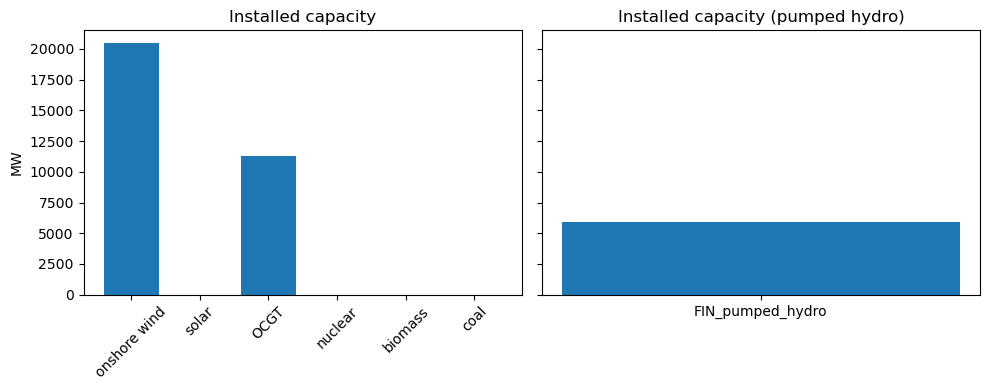

In [38]:
gen_cap = network.generators.p_nom_opt
gen_prod = network.generators_t.p
hydro_cap = network.storage_units.p_nom_opt
hydro_prod = network.links_t.p0
hydroCharge = -hydro_prod.clip(upper=0)
hydroDischarge = hydro_prod.clip(lower=0)


fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)

ax[0].bar(gen_cap.index, gen_cap.values)
ax[0].set_xticks(ticks = gen_cap.index, labels = gen_cap.index.str.replace("FIN_", "").str.replace("_", " "), rotation=45)
ax[0].set_title("Installed capacity")
ax[0].set_ylabel("MW")


ax[1].bar(hydro_cap.index, hydro_cap.values)
ax[1].set_title("Installed capacity (pumped hydro)")
plt.tight_layout()

In [41]:
print("Hydro capacity: ", hydro_cap.values[0])
print("Hydro power capacity: ", network.links.p_nom_opt.values[0])

Hydro capacity:  5906.212007950996
Hydro power capacity:  4593.160020221376


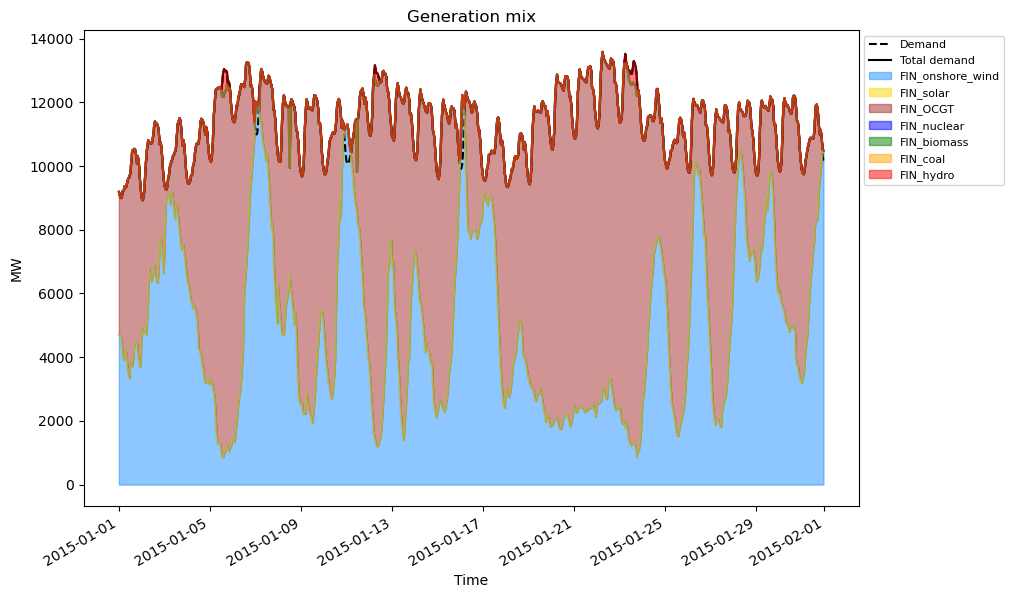

In [42]:
# Plot a week of generation
start_date = "2015-01-01"
end_date = "2015-01-31"

demand_jan = demand.loc[start_date:end_date]
generator_jan = gen_prod.loc[start_date:end_date]
hydroDischarge_jan = hydroDischarge.loc[start_date:end_date]
hydroCharge_jan = hydroCharge.loc[start_date:end_date]

tot_demand_jan = pd.concat([demand_jan, hydroCharge_jan], axis=1).sum(axis=1)
tot_supply_jan = generator_jan.join(hydroDischarge_jan, how="outer")



fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot(demand_jan.index, demand_jan.values, label="Demand", color="black", linestyle="--")
ax.plot(tot_demand_jan.index, tot_demand_jan.values, label="Total demand", color="black")
tot_supply_jan.plot.area(ax=ax, alpha=0.5, stacked=True, color=colors, legend=True)
ax.set_title("Generation mix")
ax.set_ylabel("MW")
ax.set_xlabel("Time")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=8)
plt.show()

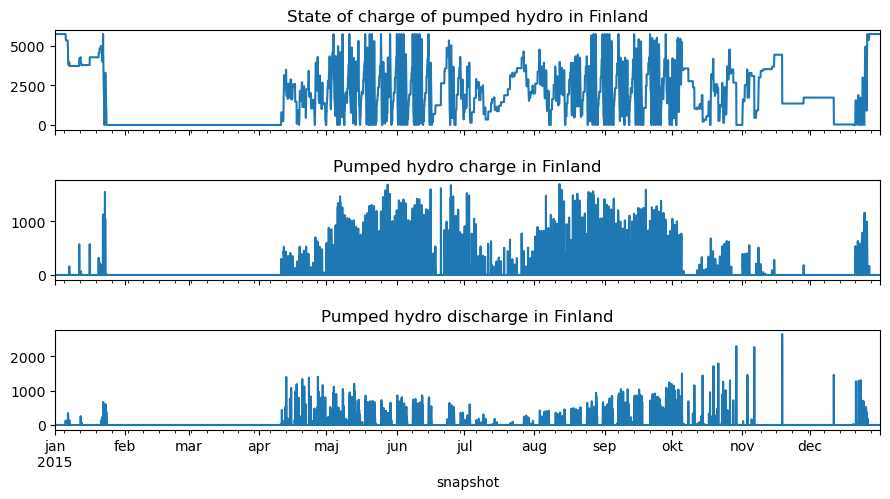

In [33]:
# Plot a week of pumped hydro generation
fig, ax = plt.subplots(3, 1, figsize=(10,7), sharex=True)
SOC = network.storage_units_t.state_of_charge#.loc[start_date:end_date]

SOC.plot(title="State of charge of pumped hydro in Finland", figsize=(10,5), ax=ax[0], legend=False);
hydroCharge.plot(title="Pumped hydro charge in Finland", figsize=(10,5), ax=ax[1], legend=False);
hydroDischarge.plot(title="Pumped hydro discharge in Finland", figsize=(10,5), ax=ax[2], legend=False);

plt.subplots_adjust(hspace=0.5, bottom=0.1, right=0.95, top=0.9)
plt.show()

Text(0.5, 1.07, 'Electricity mix')

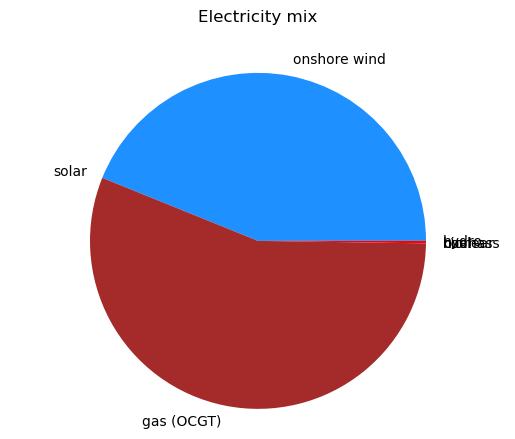

In [ ]:
# Plot electricity mix
labels = ['onshore wind',
          'solar',
          'gas (OCGT)',
          "nuclear",
          'biomass',
          'coal',
          "hydro"]
sizes = [network.generators_t.p['FIN_onshore_wind'].sum(),
         network.generators_t.p['FIN_solar'].sum(),
         network.generators_t.p['FIN_OCGT'].sum(),
         network.generators_t.p['FIN_nuclear'].sum(),
         network.generators_t.p['FIN_biomass'].sum(),
         network.generators_t.p['FIN_coal'].sum(),
         hydroDischarge.sum().values[0]
         ]

# colors=['blue', 'orange', 'brown', 'green']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

In [46]:
gen_prod.columns

Index(['FIN_onshore_wind', 'FIN_solar', 'FIN_OCGT', 'FIN_nuclear',
       'FIN_biomass', 'FIN_coal'],
      dtype='object', name='Generator')

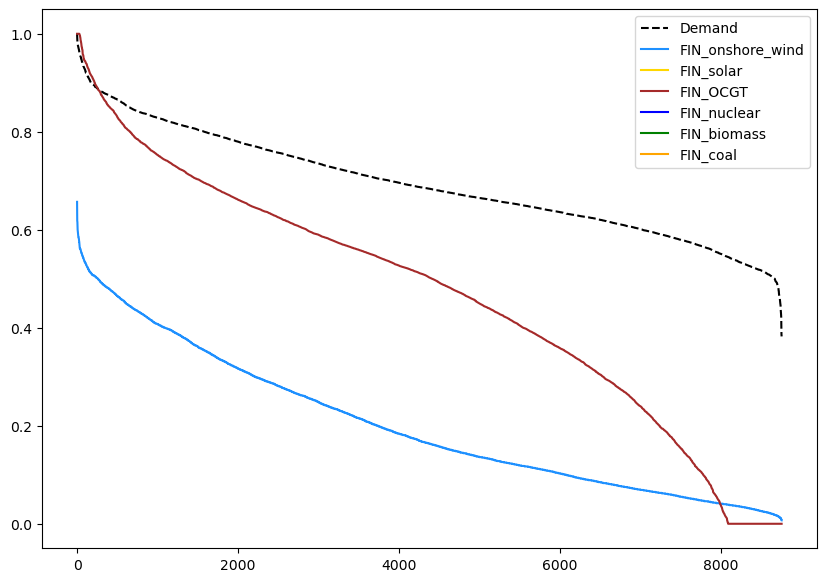

In [58]:
# Plot duration curves of generation and demand
fig, ax = plt.subplots(1, 1, figsize=(10,7))
ax.plot((demand/max(demand)).sort_values(ascending=False).reset_index(drop=True), label="Demand", color="black", linestyle="--")

for i, col in enumerate(gen_prod.columns):
    ax.plot((gen_prod[col]/gen_cap[col]).sort_values(ascending=False).reset_index(drop=True), label=col, color=colors[i])

plt.legend()
plt.show()

## B: CO2 limits

In [83]:
sensitivity_cost = {}
sensitivity_capacity = {}
sensitivity_production = {}
co2_price = pd.Series()
def system_cost(n):
    tsc = n.statistics.capex() + n.statistics.opex()
    return tsc.droplevel(0).div(1e6)  # million €/a

co2Limits = [11.9, 6, 3, 1, 0]
for co2 in co2Limits:
    network.global_constraints.loc["CO2Limit", "constant"] = co2 * 1e6
    network.optimize(solver_name="gurobi", solver_options={"outputflag": 0})
    sensitivity_cost[co2] = system_cost(network)
    sensitivity_capacity[co2] = network.generators.p_nom_opt
    sensitivity_production[co2] = network.generators_t.p.sum(axis=0)
    co2_price[co2] = -network.global_constraints.mu['CO2Limit']

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-06


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 34.78it/s]
INFO:linopy.io: Writing time: 2.08s


Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-h06vqdbs.lp


INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-h06vqdbs.lp


Reading time = 0.54 seconds


INFO:gurobipy:Reading time = 0.54 seconds


obj: 201488 rows, 87608 columns, 390179 nonzeros


INFO:gurobipy:obj: 201488 rows, 87608 columns, 390179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87608 primals, 201488 duals
Objective: 5.69e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-06


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 36.80it/s]
INFO:linopy.io: Writing time: 1.64s


Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-ehqhxpuh.lp


INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-ehqhxpuh.lp


Reading time = 0.40 seconds


INFO:gurobipy:Reading time = 0.40 seconds


obj: 201488 rows, 87608 columns, 390179 nonzeros


INFO:gurobipy:obj: 201488 rows, 87608 columns, 390179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87608 primals, 201488 duals
Objective: 5.69e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-06


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 46.79it/s]
INFO:linopy.io: Writing time: 1.52s


Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-fzn7w32r.lp


INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-fzn7w32r.lp


Reading time = 0.44 seconds


INFO:gurobipy:Reading time = 0.44 seconds


obj: 201488 rows, 87608 columns, 390179 nonzeros


INFO:gurobipy:obj: 201488 rows, 87608 columns, 390179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87608 primals, 201488 duals
Objective: 5.69e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-06


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 45.33it/s]
INFO:linopy.io: Writing time: 1.54s


Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-ud5f8sam.lp


INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-ud5f8sam.lp


Reading time = 0.40 seconds


INFO:gurobipy:Reading time = 0.40 seconds


obj: 201488 rows, 87608 columns, 390179 nonzeros


INFO:gurobipy:obj: 201488 rows, 87608 columns, 390179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87608 primals, 201488 duals
Objective: 5.69e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - outputflag: 0


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-06


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-06
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:00<00:00, 45.92it/s]
INFO:linopy.io: Writing time: 1.53s


Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-8hk4exwj.lp


INFO:gurobipy:Read LP format model from file C:\Users\jacob\AppData\Local\Temp\linopy-problem-8hk4exwj.lp


Reading time = 0.40 seconds


INFO:gurobipy:Reading time = 0.40 seconds


obj: 201488 rows, 87608 columns, 390179 nonzeros


INFO:gurobipy:obj: 201488 rows, 87608 columns, 390179 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 87608 primals, 201488 duals
Objective: 5.69e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


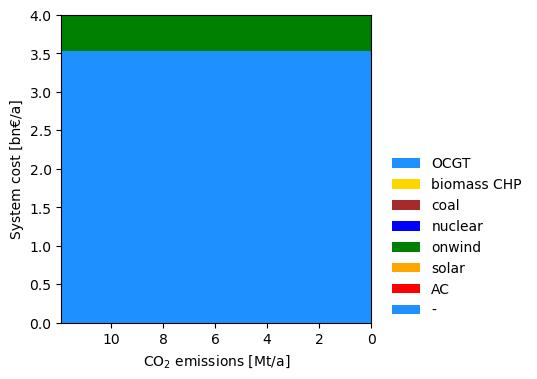

In [84]:
sens_cost = pd.DataFrame(sensitivity_cost).T.div(1e3)  # billion Euro/a
sens_cap = pd.DataFrame(sensitivity_capacity).T
sens_prod = pd.DataFrame(sensitivity_production).T.div(1e3)  # GWh/a
sens_cost.plot.area(
    stacked=True,
    linewidth=0,
    color=colors,
    figsize=(4, 4),
    xlim=(min(co2Limits), max(co2Limits)),
    xlabel=r"CO$_2$ emissions [Mt/a]",
    ylabel="System cost [bn€/a]",
    ylim=(0, 4),
)
plt.legend(frameon=False, loc=(1.05, 0))
plt.gca().invert_xaxis()

In [82]:
sens_cap

Generator,FIN_onshore_wind,FIN_solar,FIN_OCGT,FIN_nuclear,FIN_biomass,FIN_coal
2,20489.448978,0.0,11319.038102,0.0,0.0,0.0
1,20489.448978,0.0,11319.038102,0.0,0.0,0.0
0,20489.448978,0.0,11319.038102,0.0,0.0,0.0
